### Исследование внутренней размерности и анизотропии модели BERT

Задача заключается в исследовании внутренних размерностей (intrinsic dimensions, id) и анизотропии выходов блоков трансформера. В данной тетрадке рассматривается encoder-type модель bert-base-multilingual-cased.

In [157]:
import torch
import os
import gc

from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModelForCausalLM, AutoTokenizer

from safetensors import safe_open
from safetensors.torch import save_file

import llm_microscope

%config InlineBackend.figure_format='retina'

In [1]:
device = "cuda:0"

В первой части мы собираем матрицы выходов слоёв.

In [158]:
def load_txt_files_to_dict__flores(directory):
    """
    loading texts to dictionary
    """
    text_dict = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            # Flores' files with text do not have the extension. The language is indicated after the dot symbol
            text_dict[os.path.splitext(filename)[1][1:]] = text.split("\n")
    return text_dict

In [159]:
data_dir = "floresp-v2.0-rc.3/dev"
dataset_texts = load_txt_files_to_dict__flores(data_dir)

# keep only chosen languages in dataset
# languages were chosen if they existed in multilingual MMLU benchmark

languages_of_interest = ['arb_Arab', 'zho_Hant', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'ita_Latn', 'rus_Cyrl', 'spa_Latn', 'ukr_Cyrl', 'eng_Latn']

for key in list(dataset_texts.keys()):
    if key not in languages_of_interest:
        del dataset_texts[key]

In [161]:
def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first, padding_value):
        return pad_sequence([s[:max_length] for s in seq], batch_first=True, padding_value=padding_value)

    padding_value = tokenizer.pad_token_id or padding_value
    input_ids = trim_and_pad(
        [torch.tensor(example["input_ids"], dtype=torch.int32) for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )
    corpus_ids = torch.stack([torch.tensor(example["corpus_id"], dtype=torch.int32) for example in examples])

    return dict(input_ids=input_ids, corpus_ids=corpus_ids, attention_mask=input_ids.ne(padding_value))

In [162]:
def get_first_level_layer_names(model):
    """
    Get necessary layer names
    We only analize activations from transformer blocks
    """
    first_level_layers = ["embed_tokens"]
    for name, module in model.named_modules():
        if name.count(".") == 3:
            first_level_layers.append(name.split(".", 1)[1])
    return first_level_layers

In [164]:
def wrap_outputs_to_dict(outputs, batch, layer_names):
    """
    Retrieves outputs of described layers to dictionary
    """
    batch_lengths = batch["attention_mask"].sum(1)

    listed_hidden_states = []
    for hidden_state_tensor in outputs.hidden_states:
        listed_hidden_state_tensor = {
            batch["corpus_ids"][i]: hidden_state_tensor[i, : batch_lengths[i]] for i in range(len(hidden_state_tensor))
        }
        listed_hidden_states.append(listed_hidden_state_tensor)

    hidden_state_tensors = {}
    for i, hidden_state in enumerate(listed_hidden_states):
        for idx, tensor in hidden_state.items():
            hidden_state_tensors["-".join([str(idx.numpy()), layer_names[i]])] = tensor.detach().cpu()
    
    return hidden_state_tensors

In [107]:
def process_and_save_embeddings(model, model_id, dataloader, current_lang):
    """
    Saves activations
    """
    torch.cuda.empty_cache()
    layer_names = get_first_level_layer_names(model)
    keys = ["attention_mask", "corpus_ids"]

    hidden_state_tensors = {}
    for batch in tqdm(dataloader, leave=True):
        info_data = {k: batch[k] for k in keys}

        input_ids = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # in place 'or' operation
        hidden_state_tensors |= wrap_outputs_to_dict(output, info_data, layer_names)

    # This is going to be num_layers * batch_size
    print(current_lang, len(hidden_state_tensors))

    model_dir = model_id.split("/")[1]
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    filename = f"{model_dir}/{current_lang}.st"
    save_file(hidden_state_tensors, filename)

    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

    return hidden_state_tensors

In [209]:
model = AutoModelForCausalLM.from_pretrained(
        "google-bert/bert-base-multilingual-cased",
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=device,
    )

In [169]:
model_names = [
    "google-bert/bert-base-multilingual-cased"
]

for model_id in model_names:

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=device,
    )

    model_dir = model_id.split("/")[1]
    batch_size = 16

    for current_lang in (tokenized_texts.keys()):
        filename = f"{model_dir}/{current_lang}.st"

        current_dataset = [
            {"input_ids": input_ids, "corpus_id": i}
            for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"]) # для всех пронумерованных токенизированных текстов
        ]

        current_sampler = LengthGroupedSampler(
            dataset=current_dataset,
            batch_size=batch_size,
        )

        current_loader = DataLoader(
            current_dataset,
            collate_fn=data_collator,
            sampler=current_sampler,
            batch_size=batch_size,
            shuffle=False,
        )

        hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
100%|███████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 20.47it/s]


ukr_Cyrl 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.11it/s]


rus_Cyrl 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.06it/s]


spa_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 29.42it/s]


eng_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.51it/s]


ita_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.02it/s]


nld_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.04it/s]


fra_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.45it/s]


deu_Latn 12974


100%|███████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 21.42it/s]


arb_Arab 12974


### Подсчет метрик

In [187]:
def unfold_dict(d, keep_ids=None):
    hierarchical = {}
    keep_ids = set(keep_ids) if keep_ids is not None else set()
    for key, value in tqdm(d.items()):
        sentence_id, layer = key.split("-")
        if layer not in hierarchical:
            hierarchical[layer] = {}
        if int(sentence_id) in keep_ids:
            hierarchical[layer][sentence_id + "_full"] = value
        # с усреднением:
        # hierarchical[layer][sentence_id] = value.mean(0, keepdims=True)
        # без усреднения:
        hierarchical[layer][sentence_id] = value
    return hierarchical

In [188]:
hidden_states = {}

for language in dataset_texts.keys():
    filename = f"{model_dir}/{language}.st"
    hidden_states[language] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language][key] = f.get_tensor(key)
        hidden_states[language] = unfold_dict(hidden_states[language])

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

In [200]:
# сохраняем словарь код языка - название слоя - активации

language_en = "eng_Latn"

if language_en not in hidden_states:
    filename = f"{model_dir}/{language}.st"
    hidden_states[language_en] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language_en][key] = f.get_tensor(key)
        hidden_states[language_en] = unfold_dict(hidden_states[language_en])
        
len(hidden_states[language_en]['embed_tokens'])

998

In [201]:
hidden_states_en = hidden_states[language_en]
longest_sentence_id, longest_sentence_en = max(enumerate(hidden_states_en["embed_tokens"]), key=lambda x: len(x[1]))
longest_sentence = dataset_texts[language_en][longest_sentence_id]
tokenized_sentence_lens = [len(emb) for emb in hidden_states_en["embed_tokens"]]
percentile = 50
pcen = np.percentile(tokenized_sentence_lens, percentile, interpolation="nearest")
median_sentence_id = abs(tokenized_sentence_lens - pcen).argmin()

### Intrinsic dimensionality

In [204]:
def intrinsic_dimension_custom(emb, device, debug=False, reduction_factor=5, convert_dtype=torch.float32):
    """
    emb: n x dim torch tensor
    """
    with torch.no_grad():
        eps = 1e-8
        embeddings = emb.to(convert_dtype).to(device)
        embeddings = embeddings - embeddings.mean(dim=0, keepdim=True)
        avg_len = (embeddings*embeddings).sum(dim=1).sqrt().mean()
        embeddings = embeddings / avg_len

        r1 = []
        r2 = []
        n = len(embeddings)
        for i in (range(n)):
            dsts = torch.nn.functional.pairwise_distance(
                embeddings[i, None, :],
                embeddings[None, :, :],
                eps=0
            )[0]
            dsts = torch.cat([dsts[:i], dsts[i+1:]])
            r1.append(torch.kthvalue(dsts, k=1)[0])
            r2.append(torch.kthvalue(dsts, k=2)[0])
        r1 = torch.tensor(r1).to(device)
        r2 = torch.tensor(r2).to(device)
        bad_cases = (r1 < eps)
        r1[bad_cases] = eps
        r2[bad_cases] = eps
        mu = r2 / r1
        mu[bad_cases] = -1
    
        mu, ind = torch.sort(mu)
        all_mu = mu.clone().cpu().detach()
        useless_items = int((mu <= 1+eps).sum()) 
        mu = mu[useless_items:]
        n = mu.shape[0]
        if debug:
            print('Removed points: ', useless_items)
            plt.plot(mu.cpu().detach().numpy())
            plt.show()

        f_emp = torch.arange(1+useless_items, n + 1 + useless_items, device=device) / (n + useless_items)
        num_dots_to_use = min(n  // reduction_factor, n - 1)
        
        mu_log = torch.log(mu)[:num_dots_to_use]
        dist_log = -torch.log(1 - f_emp)[:num_dots_to_use]

        if debug:
            print('Regression points:', len(mu_log))
            plt.scatter(mu_log.cpu().detach().numpy(), dist_log.cpu().detach().numpy(), marker='.')
            plt.show()

        dim = float((mu_log*dist_log).sum() / (mu_log*mu_log).sum())

        if debug:
            print('Dim: ', dim)
    return float(dim) #, all_mu

In [196]:
id_estimates = defaultdict(lambda: defaultdict(dict))

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        sentence_emb = torch.cat([sentences[i] for i in idx])
        id_estimate = intrinsic_dimension_custom(sentence_emb, reduction_factor=4, convert_dtype=torch.float16, device="cuda:0")
        id_estimates[language][layer][median_sentence_id] = id_estimate

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

layer:  embed_tokens
id_estimate:  2.774035930633545
layer:  encoder.layer.0
id_estimate:  9.191276550292969
layer:  encoder.layer.1
id_estimate:  9.259427070617676
layer:  encoder.layer.10
id_estimate:  12.978987693786621
layer:  encoder.layer.11
id_estimate:  12.46185302734375
layer:  encoder.layer.2
id_estimate:  9.735753059387207
layer:  encoder.layer.3
id_estimate:  9.977635383605957
layer:  encoder.layer.4
id_estimate:  11.001252174377441
layer:  encoder.layer.5
id_estimate:  12.891240119934082
layer:  encoder.layer.6
id_estimate:  13.406492233276367
layer:  encoder.layer.7


In [205]:
list_layers = set(hidden_states[language_en].keys())
list_layers.remove("embed_tokens")
list_layers = list(list_layers)
list_layers.sort(key=lambda x: int(x.split(".")[2]))
list_layers = ["embed_tokens"] + list_layers
list_layers

['embed_tokens',
 'encoder.layer.0',
 'encoder.layer.1',
 'encoder.layer.2',
 'encoder.layer.3',
 'encoder.layer.4',
 'encoder.layer.5',
 'encoder.layer.6',
 'encoder.layer.7',
 'encoder.layer.8',
 'encoder.layer.9',
 'encoder.layer.10',
 'encoder.layer.11']

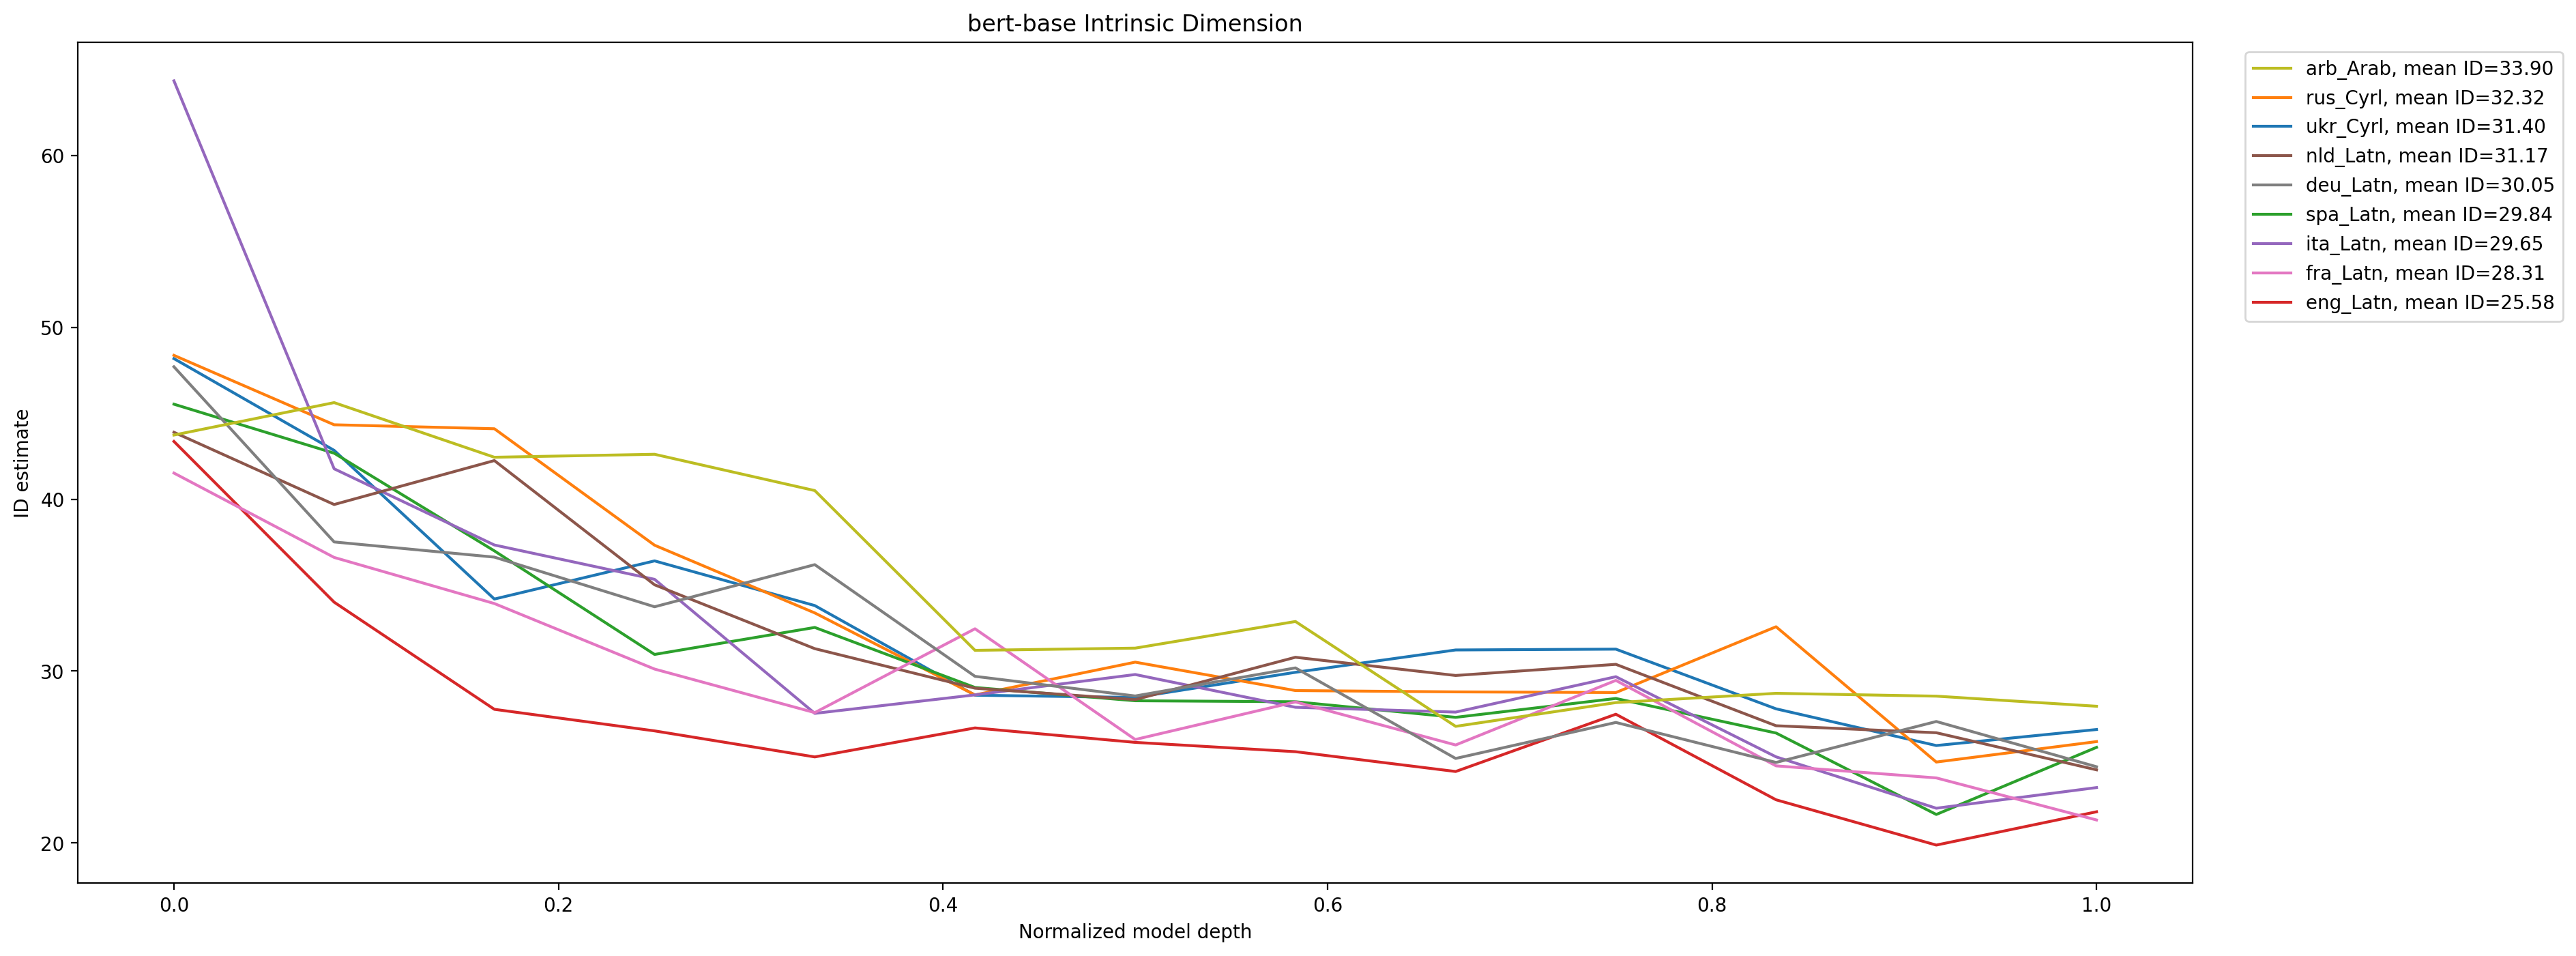

In [ ]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Intrinsic Dimension")

mean_metric_list = []

for language, estimate in id_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean ID={mean_metric:.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("ID estimate")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))
plt.show()

### Anisotropy

In [ ]:
anisotropy_estimates = defaultdict(lambda: defaultdict(dict))

def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True)
    # embeddings = emb 
    num_iters = 100    
    x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype)
    for i in range(num_iters):  # критерий останова        
        x /= torch.norm(x)
        x = x @ embeddings
        x /= torch.norm(x)
        x = embeddings @ x
        # print(torch.norm(x))    
    sigma = torch.norm(x)
    anisotropy = sigma ** 2 / torch.norm(embeddings) ** 2    
    return anisotropy

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
            
        sentence_emb = torch.cat([sentences[i] for i in idx]).to(dtype=torch.float32, device="cuda:2")[:-1]
        anisotropy_estimate = calculate_anisotropy_torch(sentence_emb)
        # anisotropy_estimate = llm_microscope.calculate_anisotropy_torch(sentence_emb)
        anisotropy_estimates[language][layer][median_sentence_id] = anisotropy_estimate.to('cpu')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [208]:
keys_layers = list(hidden_states['arb_Arab'].keys())[1:]
keys_layers = sorted(keys_layers, key=lambda x: int(x.split('.')[-1]))
keys_layers = ["embed_tokens"] + keys_layers

for layer_key in keys_layers:
    arab_sent_embs = hidden_states['arb_Arab'][layer_key]
    idx = [k for k in arab_sent_embs.keys() if "_full" not in k]
    idx.sort(key=int)
    
    sentence_emb = torch.cat([arab_sent_embs[i] for i in idx]).to(dtype=torch.float32, device="cuda:2")[:-1]
    sentence_emb = sentence_emb - sentence_emb.mean(dim=0, keepdim=True)
    print(f"{layer_key} Rank: {torch.linalg.matrix_rank(sentence_emb)}")
    print(f"{layer_key}: {torch.linalg.svdvals(sentence_emb)[:6].cpu().numpy()}")
    # print(f"{layer_key}: {torch.linalg.svdvals(sentence_emb)[:6] / torch.norm(sentence_emb)}")
    print(f"{layer_key}: {torch.linalg.svdvals(sentence_emb)[:1] / torch.norm(sentence_emb)}")

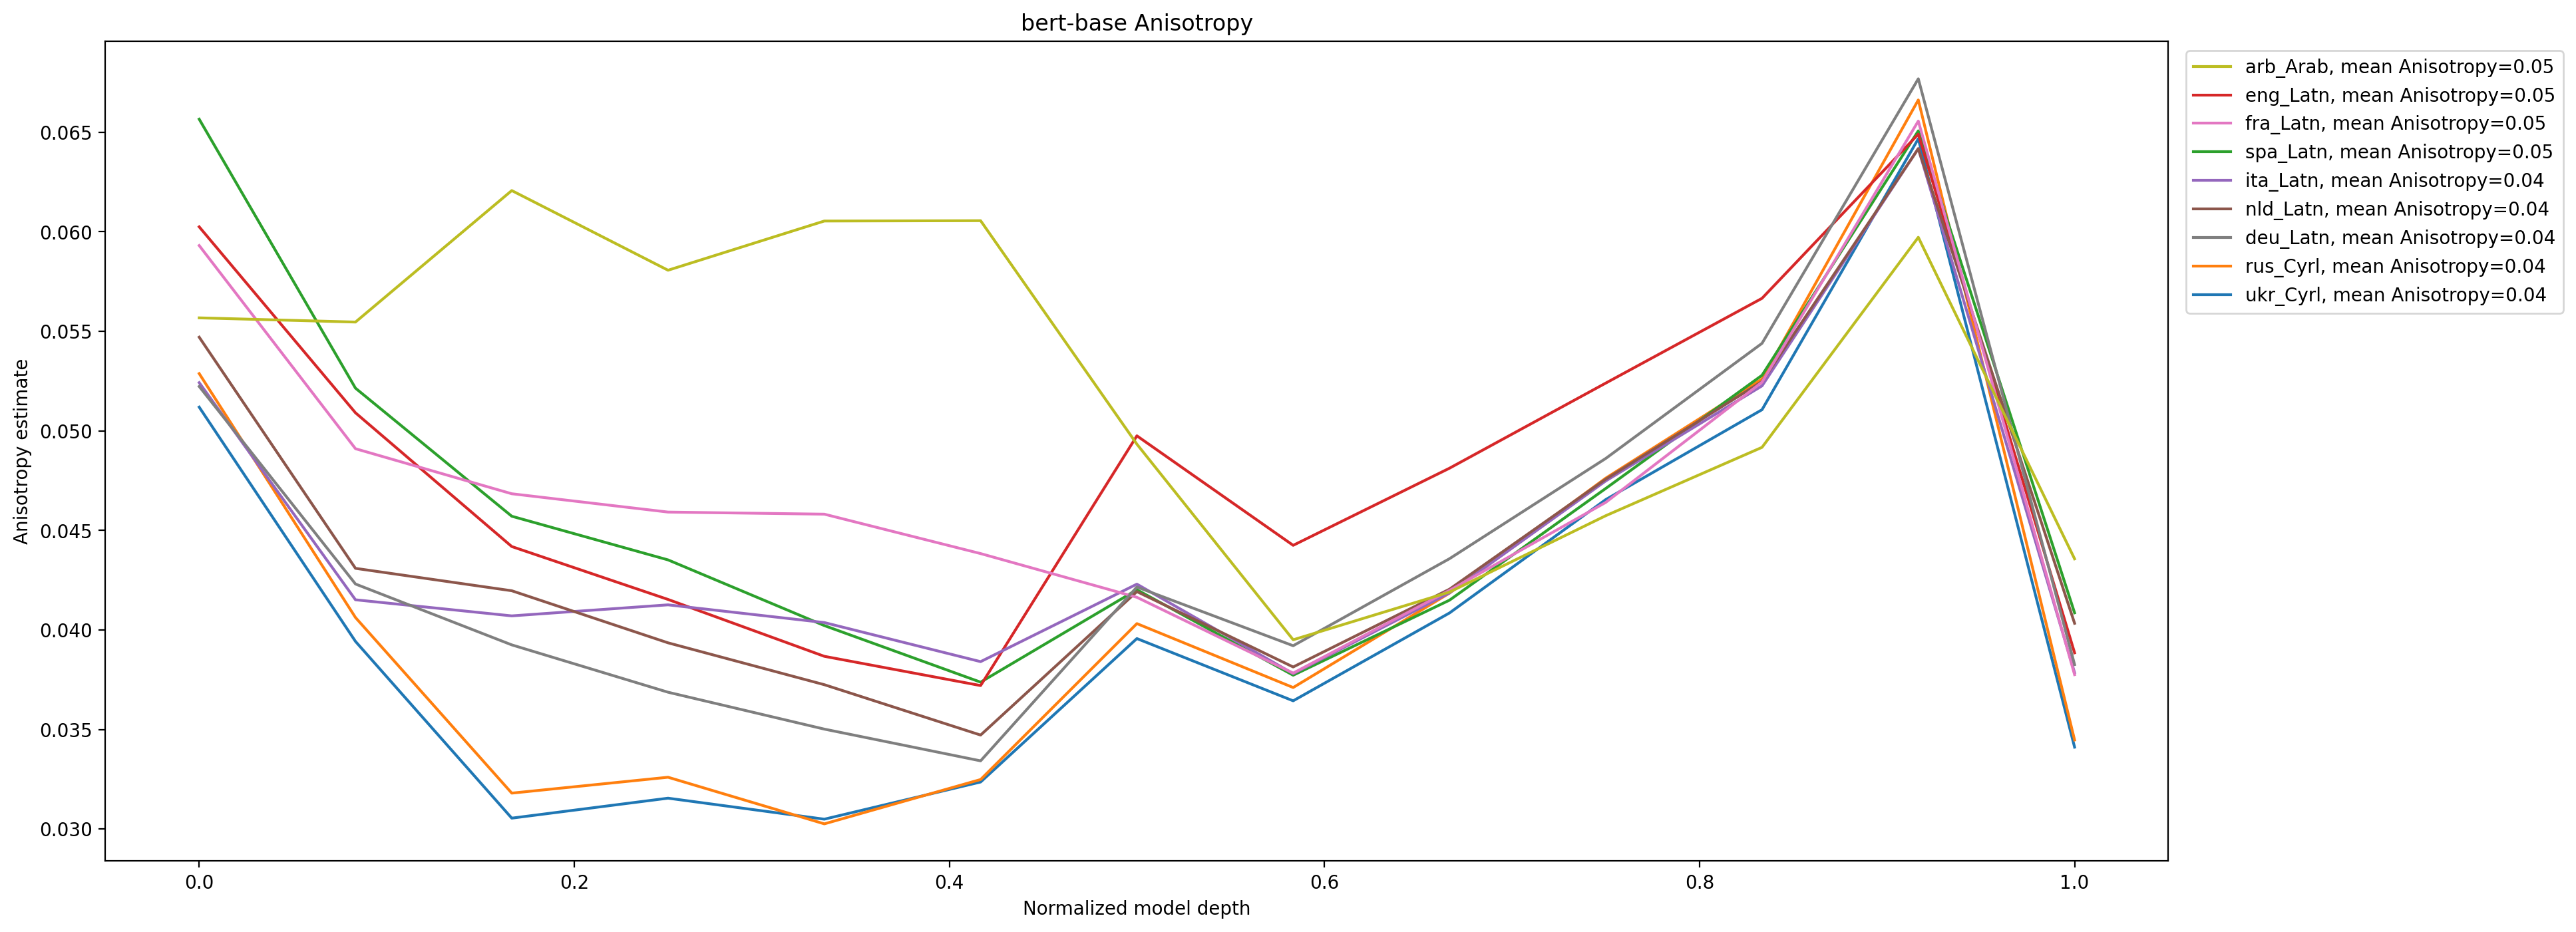

In [ ]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy")

mean_metric_list = []

for language, estimate in anisotropy_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])

    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean Anisotropy={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Anisotropy estimate")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))

plt.show()

Выравниваю ось y до 1, чтобы сопоставить со статьей Razgigaev et al.:

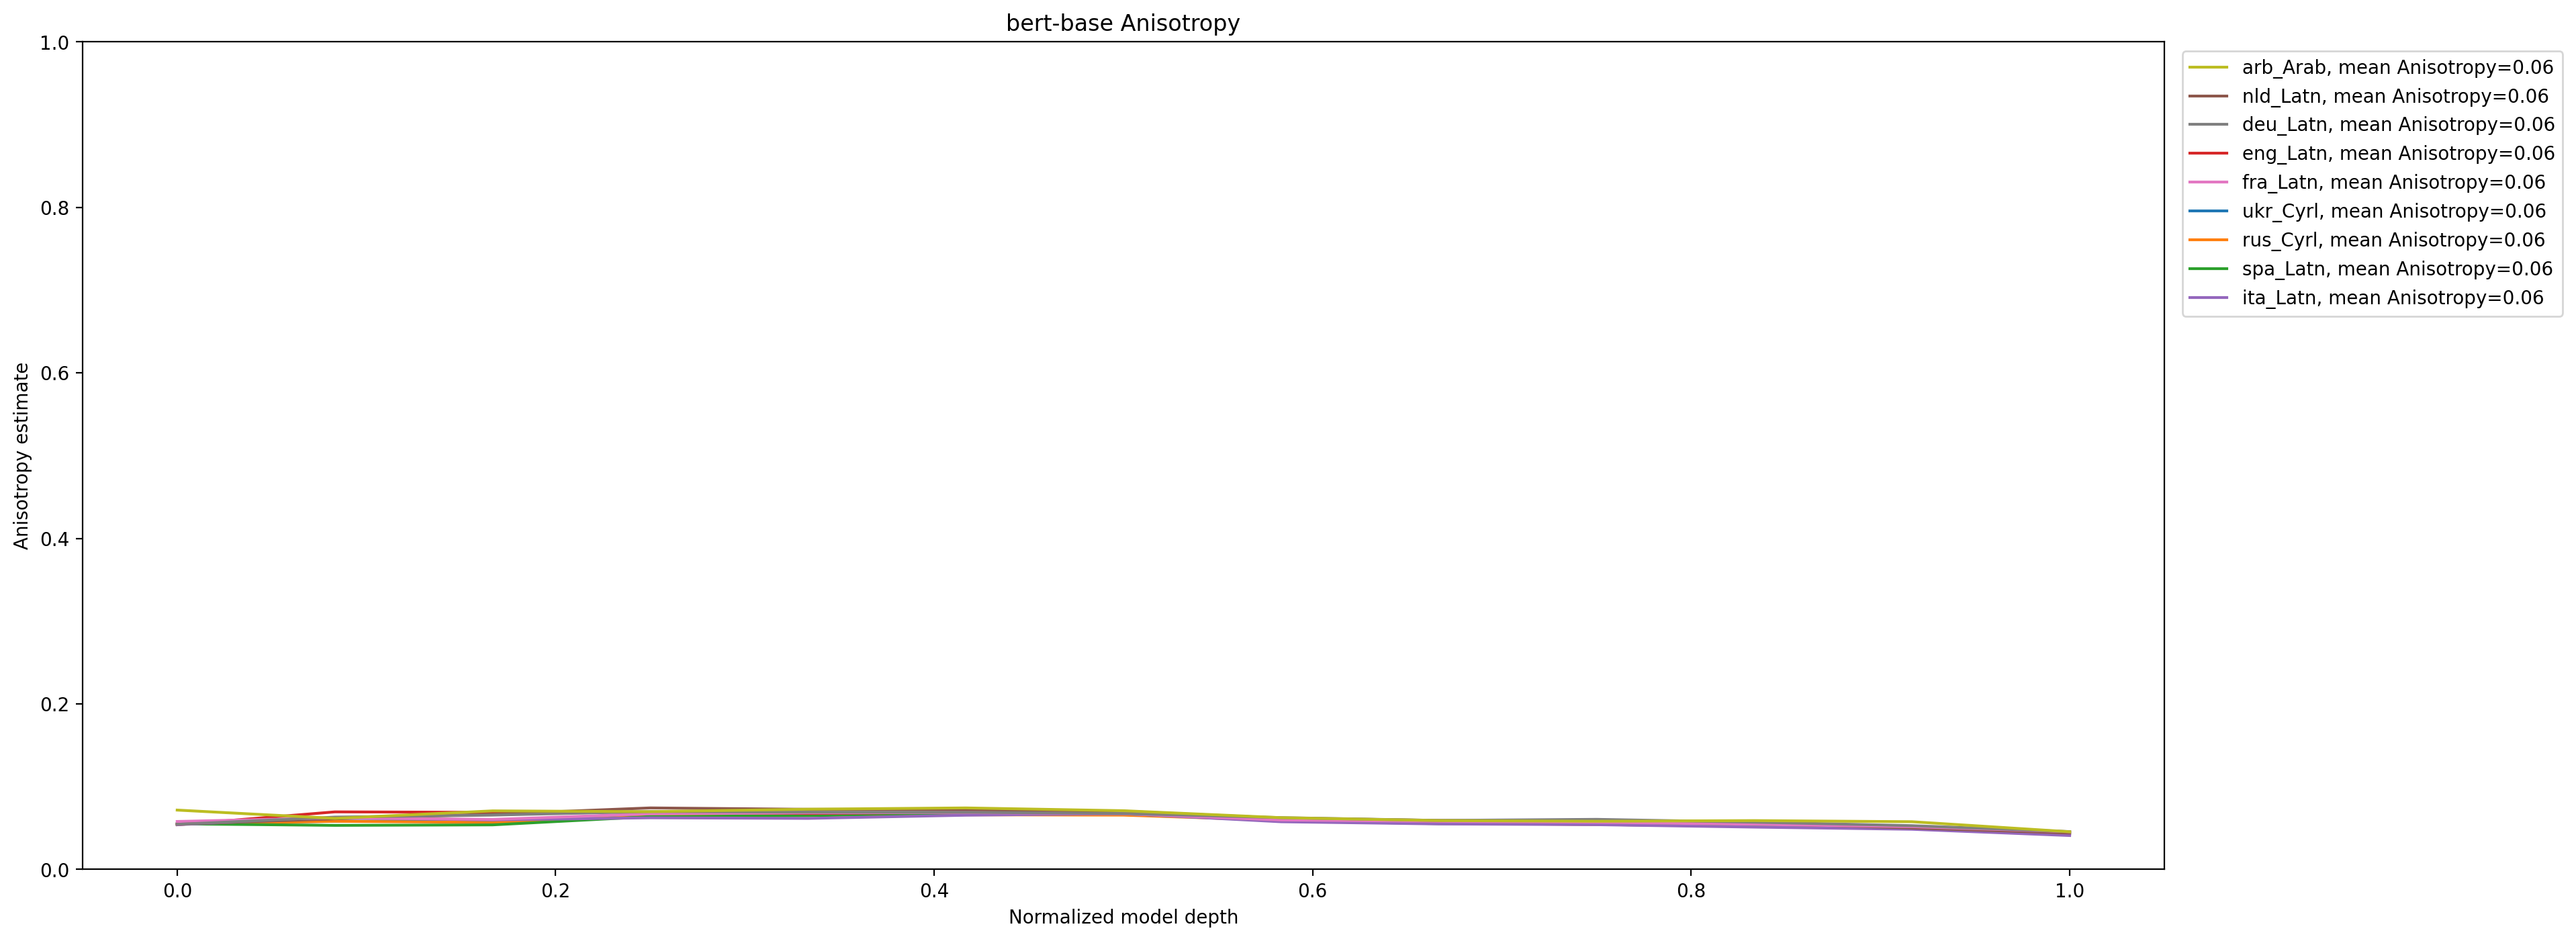

In [ ]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy")

mean_metric_list = []

for language, estimate in anisotropy_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])

    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean Anisotropy={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Anisotropy estimate")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))


ax = plt.gca()
ax.set_ylim([0, 1])
plt.savefig("results/bert_anis.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

### Correlation of English and other languages

In [ ]:
cosine_sims = defaultdict(lambda: defaultdict(dict))


idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    if language == language_en:
        continue
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
            
        sentence_emb = torch.cat([sentences[i] for i in idx]).to(dtype=torch.float32, device="cuda:0")[:-1]
        english_sentence_emb = torch.cat([hidden_states[language_en][layer][i] for i in idx]).to(dtype=torch.float32, device="cuda:0")[:-1]
        cosine_sim = llm_microscope.procrustes_similarity(sentence_emb, english_sentence_emb)
        # cosine_sim = llm_microscope.procrustes_similarity_centered(sentence_emb, english_sentence_emb)
        cosine_sims[language][layer][median_sentence_id] = cosine_sim

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

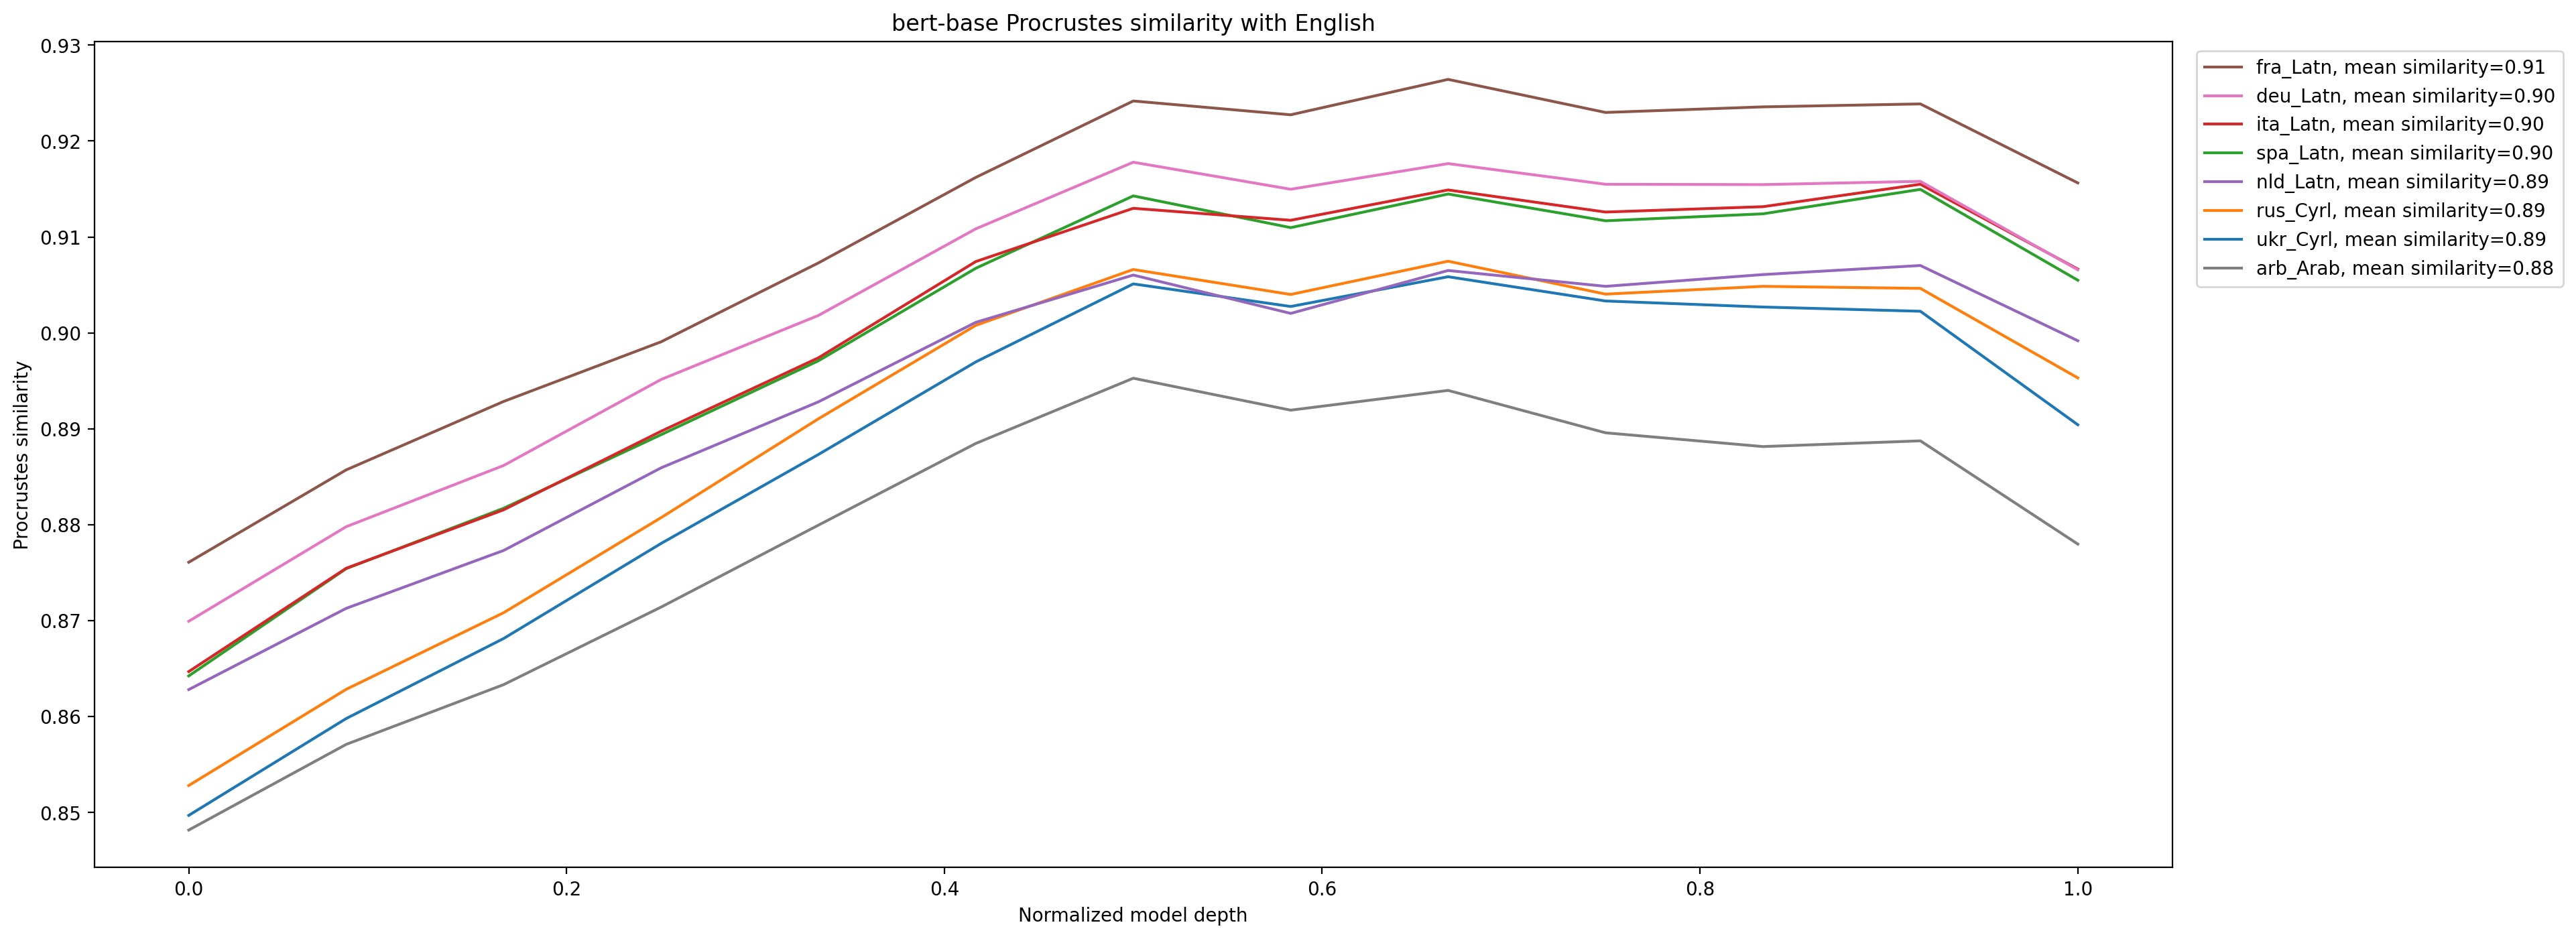

In [ ]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Procrustes similarity with English")

mean_metric_list = []

for language, estimate in cosine_sims.items():
    if language == "en":
        continue
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])
        
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean similarity={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Procrustes similarity")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))

plt.show()